In [52]:
from pynq import Overlay
from pynq import Xlnk
from pynq import allocate
from pynq import DefaultIP
import pickle
import cv2
import time
import numpy as np

overlay = Overlay("current_cnn.bit")
conv = overlay.conv_0
max_pool2D = overlay.max_pool2_0
overlay.is_loaded()

True

In [42]:
import struct
from array import array
from os.path import join

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)    


In [ ]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

input_path = './'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()   

In [44]:
def Run_Conv(conv_ip, chin, chout, kx, ky, win, hin, stride, padding, feature_in, weight, bias, feature_out):
    conv_ip.write(0x10, chin)
    conv_ip.write(0x18, chout)
    conv_ip.write(0x20, kx)
    conv_ip.write(0x28, ky)
    conv_ip.write(0x30, win)
    conv_ip.write(0x38, hin)
    conv_ip.write(0x40, stride)
    conv_ip.write(0x48, padding)
    conv_ip.write(0x50, feature_in.physical_address)
    conv_ip.write(0x58, weight.physical_address)
    conv_ip.write(0x68, bias.physical_address)
    conv_ip.write(0x60, feature_out.physical_address)
    conv_ip.write(0, (conv.read(0)&0x80)|0x01 ) #start conv IP
    while True:
        if conv_ip.read(0x00) & 0x2:  # 检查 ap_done 位
            print('done')
            break
            
def Run_maxpool2D(pool, chin, h, w, feature_in, feature_out):
    pool.write(0x10,h)
    pool.write(0x18,w)
    pool.write(0x20,chin)
    pool.write(0x28,feature_in.physical_address)
    pool.write(0x30,feature_out.physical_address)
    pool.write(0, (pool.read(0)&0x80)|0x01 ) #start conv IP
    while True:
        if pool.read(0x00) & 0x2:  # 检查 ap_done 位
            print('done')
            break
            

In [54]:

with open("model_bin_param/conv1.weight.bin", 'rb') as f:
    data = f.read()
    # 使用 NumPy 从二进制数据中解析数组
    conv_w1_array = np.frombuffer(data, dtype=np.float32)  # 假设数据类型为 float32
    conv_w1 = conv_w1_array.reshape(1, 6, 5, 5)
# print(conv_w1)

with open("model_bin_param/conv1.bias.bin", 'rb') as f:
    data = f.read()
    conv_b1_array = np.frombuffer(data, dtype=np.float32)  
    conv_b1 = conv_b1_array
# print(conv_b1)

with open("model_bin_param/conv2.weight.bin", 'rb') as f:
    data = f.read()
    conv_w2_array = np.frombuffer(data, dtype=np.float32)  
    conv_w2 = conv_w2_array.reshape(6, 16, 5, 5)
# print(conv_w2)

with open("model_bin_param/conv2.bias.bin", 'rb') as f:
    data = f.read()
    conv_b2_array = np.frombuffer(data, dtype=np.float32)  
    conv_b2 = conv_b2_array
# print(conv_b2)       

with open("model_bin_param/conv3.weight.bin", 'rb') as f:
    data = f.read()
    conv_w3_array = np.frombuffer(data, dtype=np.float32)  
    conv_w3 = conv_w3_array.reshape(16, 120, 4, 4)
# print(conv_w3)  

with open("model_bin_param/conv3.bias.bin", 'rb') as f:
    data = f.read()
    conv_b3_array = np.frombuffer(data, dtype=np.float32)  
    conv_b3 = conv_b3_array
# print(conv_b3)    

with open("model_bin_param/fc1.weight.bin", 'rb') as f:
    data = f.read()
    conv_w4_array = np.frombuffer(data, dtype=np.float32)  
    conv_w4 = conv_w4_array.reshape(120,84)
# print(conv_w4)  

with open("model_bin_param/fc1.bias.bin", 'rb') as f:
    data = f.read()
    conv_b4_array = np.frombuffer(data, dtype=np.float32)  
    conv_b4 = conv_b4_array
# print(conv_b4)     

with open("model_bin_param/fc2.weight.bin", 'rb') as f:
    data = f.read()
    conv_w5_array = np.frombuffer(data, dtype=np.float32)  
    conv_w5 = conv_w5_array.reshape(84,10)
# print(conv_w5)

with open("model_bin_param/fc2.bias.bin", 'rb') as f:
    data = f.read()
    conv_b5_array = np.frombuffer(data, dtype=np.float32)  
    conv_b5 = conv_b5_array
# print(conv_b5)

with open("model_bin_param/img2.bin", 'rb') as f:
    data = f.read()
    img_array = np.frombuffer(data, dtype=np.float32)  
    img2 = img_array.reshape(28,28)

In [55]:
# print(img)
# print(conv_w1.shape)

(28, 28)
2


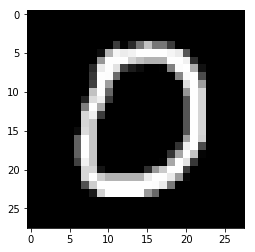

In [79]:
# 获取某个图像的像素大小
img = np.array(x_test[10], dtype='u1') /255
# print(images_n)
print(img.shape)
print(y_test[1])
plt.imshow(img, cmap=plt.cm.gray)
plt.show()


In [68]:
xlnk = Xlnk()
# Allocate memory for input data
img_cma = xlnk.cma_array(shape=(1, 28, 28), cacheable=0, dtype=np.float32)
conv_w1_cma = xlnk.cma_array(shape=(1, 6, 5, 5), cacheable=0, dtype=np.float32)
conv_b1_cma = xlnk.cma_array(shape=(6), dtype=np.float32)
conv_w2_cma = xlnk.cma_array(shape=(6, 16, 5, 5), cacheable=0, dtype=np.float32)
conv_b2_cma = xlnk.cma_array(shape=(16), dtype=np.float32)
conv_w3_cma = xlnk.cma_array(shape=(16, 120, 4, 4), cacheable=0, dtype=np.float32)
conv_b3_cma = xlnk.cma_array(shape=(120), dtype=np.float32)
conv_w4_cma = xlnk.cma_array(shape=(120,84), cacheable=0, dtype=np.float32)
conv_b4_cma = xlnk.cma_array(shape=(84), dtype=np.float32)
conv_w5_cma = xlnk.cma_array(shape=(84,10), cacheable=0, dtype=np.float32)
conv_b5_cma = xlnk.cma_array(shape=(10), dtype=np.float32)

conv1_feature_out = xlnk.cma_array(shape=(6, 24, 24), dtype=np.float32)
pool1_feature_out = xlnk.cma_array(shape=(6, 12, 12), dtype=np.float32)
conv2_feature_out = xlnk.cma_array(shape=(16, 8, 8), dtype=np.float32)
pool2_feature_out = xlnk.cma_array(shape=(16, 4, 4), dtype=np.float32)
conv3_feature_out = xlnk.cma_array(shape=(120,1,1), dtype=np.float32)
conv4_feature_out = xlnk.cma_array(shape=(84), dtype=np.float32)
conv5_feature_out = xlnk.cma_array(shape=(10), dtype=np.float32)

# shape=(10,84)
# shape1=6
# conv_w5 = np.zeros(shape)
# conv_b1 = np.zeros(shape1)

np.copyto(img_cma, img)
np.copyto(conv_w1_cma, conv_w1)
np.copyto(conv_b1_cma, conv_b1)
np.copyto(conv_w2_cma, conv_w2)
np.copyto(conv_b2_cma, conv_b2)
np.copyto(conv_w3_cma, conv_w3)
np.copyto(conv_b3_cma, conv_b3)
np.copyto(conv_w4_cma, conv_w4)
np.copyto(conv_b4_cma, conv_b4)
np.copyto(conv_w5_cma, conv_w5)
np.copyto(conv_b5_cma, conv_b5)
print(conv_w1_cma)
print(conv_b1_cma)
# if np.array_equal(conv_w1_cma, conv_w1):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_w2_cma, conv_w2):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_w3_cma, conv_w3):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_w4_cma, conv_w4):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_w5_cma, conv_w5):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_b1_cma, conv_b1):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_b2_cma, conv_b2):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_b3_cma, conv_b3):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_b4_cma, conv_b4):
#     print(1)
# else:
#     print(0)
# if np.array_equal(conv_b5_cma, conv_b5):
#     print('same')
# else:
#     print(0)
    
# print(img)

[[[[-0.09437244 -0.09024699  0.06099947  0.14703974  0.01258508]
   [ 0.0599516  -0.1876938  -0.30132908 -0.0191188  -0.25771987]
   [-0.10694439 -0.09919756 -0.13496776 -0.23989199 -0.0225703 ]
   [-0.16701132 -0.04415072 -0.14945532 -0.10438969  0.12235595]
   [-0.01040867  0.43392119  0.38457355  0.31648105 -0.01792734]]

  [[-0.13847528 -0.05266434 -0.14994165 -0.22143574 -0.02761282]
   [ 0.04572675 -0.20290662 -0.19492783 -0.08062179  0.10467463]
   [-0.16658093 -0.10002811 -0.16022687 -0.0406004   0.26063389]
   [-0.1885155  -0.11577988 -0.15089154  0.07837743  0.25949839]
   [ 0.00254942 -0.23847155  0.02581829  0.12375706  0.18103114]]

  [[ 0.03014438 -0.21748306 -0.0896283  -0.13684087 -0.09194598]
   [ 0.06624357 -0.02271346  0.17185856 -0.12020604 -0.25503808]
   [ 0.2149947   0.17743747  0.34478071  0.32858735  0.04461452]
   [ 0.16991992  0.18789686  0.06236492  0.32200813  0.26737043]
   [-0.23541188 -0.26380348 -0.15038586 -0.01044025  0.17748342]]

  [[-0.08533452 -0.

In [69]:
# Run_Conv(conv, chin, chout, kx, ky, win, hin, stride, padding, images_n, conv_w1, conv_b1, feature_out)
# Run_maxpool2D(pool, chin, h, w, feature_in, feature_out)

Run_Conv(conv, 1, 6, 5, 5, 28, 28, 1, 0, img_cma, conv_w1_cma, conv_b1_cma, conv1_feature_out)
Run_maxpool2D(max_pool2D,6,24,24,conv1_feature_out,pool1_feature_out)
Run_Conv(conv, 6, 16, 5, 5, 12, 12, 1, 0, pool1_feature_out, conv_w2_cma, conv_b2_cma, conv2_feature_out)
Run_maxpool2D(max_pool2D,16,8,8,conv2_feature_out,pool2_feature_out)
Run_Conv(conv,16,120,4,4,4,4,1,0,pool2_feature_out,conv_w3_cma,conv_b3_cma,conv3_feature_out)

Run_Conv(conv,120,84,1,1,1,1,1,0,conv3_feature_out,conv_w4_cma,conv_b4_cma,conv4_feature_out)
Run_Conv(conv,84,10,1,1,1,1,1,0,conv4_feature_out,conv_w5_cma,conv_b5_cma,conv5_feature_out)


def get_max_index(x):
    return np.argmax(x)
max_index = get_max_index(conv5_feature_out)

print("Max Index:", max_index)

# print(conv3_feature_out.shape)
print("conv2 result:")
# print(conv_w5_cma)
print(conv5_feature_out)

done
done
done
done
done
done
done
Max Index: 7
conv2 result:
[ 11.04039192 -21.0134182   10.50159931   9.79804134 -40.5333786
 -30.31669807 -54.63976288  59.19088364  10.50305653   9.9992857 ]
